Learns non-chaotic lorenz with $\rho(t)$ transitioning from 14 to 15.  

In [1]:
# Import the necessary packages:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
#import Plot3D as plot3d

#Neural ODE library
import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Generating Data

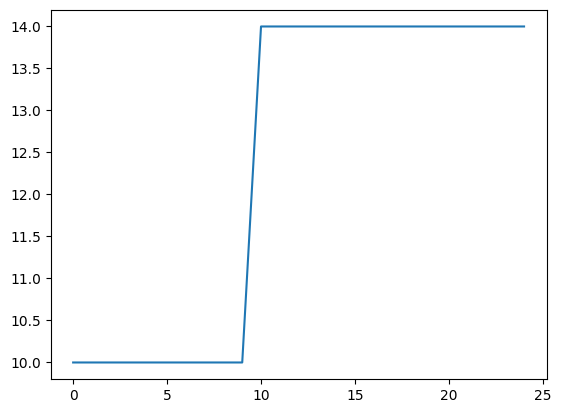

In [2]:
#r_vals = np.arange(14, 15, 1, dtype=np.float32)
r_vals = [10.0, 14.0]
def rho(t, r_vals = r_vals, step = 10):
    if t < step:
        return r_vals[0]
    elif t >= step:
        return r_vals[1]

plt.plot([rho(t) for t in range(0, 25)])

In [3]:
lorenz = ds.Lorenz(rho = rho)

#Generating data from Lorenz System with fixed parameters
dt = 0.05
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]
time_spans = [(0, 15)]
list = []

for t_span in time_spans:
    out = lorenz.solve(x0 = initial_conditions, t_span = t_span, dt = dt)
    list.append(np.expand_dims(out, axis=0))

data_full = np.concatenate(list, axis=0)
data_full.shape

(1, 300, 2, 3)

### Normalizing Data

In [4]:
norm = nodes.normalize_data(data_full.reshape(-1, 3))
data_norm = norm.normalize(data_full)

## Plotting 

In [5]:
data_norm.shape

(1, 300, 2, 3)

In [6]:
def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

    

In [7]:
data_norm[0, :, 0, 0].shape

(300,)

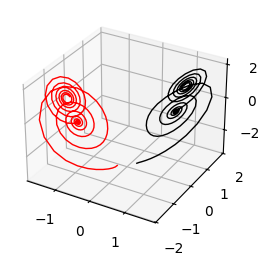

In [8]:

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
ax1.plot(xs=data_norm[0, :, 0, 0], ys=data_norm[0, :, 0, 1], zs=data_norm[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[0, :, 1, 0], ys=data_norm[0, :, 1, 1], zs=data_norm[0, :, 1, 2], color = 'red', linewidth = 1)   



# Training Neural ODE

In [9]:
model = nodes.Piecewise_Auto_NODE(spatial_dim=3, depth=2, width = 30, time_range=[0, 15], num_breakpoints=10, activation_func=nn.Tanh())

In [10]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
#t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

In [11]:
times = np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])
t_eval_tensor = torch.tensor(times)
t_eval_tensor.shape

torch.Size([1, 300])

## Single Loop 

In [12]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [13]:

t_eval_tensor.shape[1]

300

In [14]:
#Single training loop
optimizer.zero_grad()

pred_x_list = []
for i in range(t_eval_tensor.shape[0]):

    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(1.7412, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([ 0.2004, -0.0763,  0.1643, -0.1025, -0.1506,  0.1536, -0.1216,  0.0654,
         0.0544, -0.0016])



In [15]:
optimizer.zero_grad()




pred_x = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_tensor[0, :].float(), method='rk4', options={'step_size': dt})


loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor[0, :, :, :].float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(1.5756, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([ 0.1720, -0.0892,  0.1627, -0.0978, -0.1438,  0.1476, -0.1152,  0.0579,
         0.0565, -0.0033])



## Main Training Loop

In [16]:
def batch(data: torch.tensor, t: torch.tensor, batch_length: int, num_batch: int): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).

    Modifed to allow for multiple time spans

    Parameters:
    -----------       
    data : torch.tensor
        The full dataset from which to sample batches. (num_time_spans, time, traj, dim)

    t : torch.tensor
        The corresponding time tensor. (num_time_spans, time)
    '''
    data_length = data.shape[1]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[:, ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[:, ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))
        
        #Each batch has shape (num_time_spans, batch_length, traj, dim) and each batch time has shape (num_time_spans, batch_length)

        return batch_list, batch_time_list

In [17]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [18]:
batch_length = 20
num_batch = 15
num_epochs = 1000

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float()) 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     
    
   

  0%|          | 1/1000 [00:09<2:46:16,  9.99s/it]

Epoch 0, Loss: 1.2234638929367065


  2%|▏         | 21/1000 [02:52<2:18:26,  8.48s/it]

Epoch 20, Loss: 0.7820562124252319


  4%|▍         | 41/1000 [05:31<2:11:33,  8.23s/it]

Epoch 40, Loss: 0.7709364891052246


  6%|▌         | 61/1000 [08:10<2:09:01,  8.24s/it]

Epoch 60, Loss: 0.7521546483039856


  8%|▊         | 81/1000 [10:49<2:07:00,  8.29s/it]

Epoch 80, Loss: 0.7162687182426453


 10%|█         | 101/1000 [13:27<2:04:59,  8.34s/it]

Epoch 100, Loss: 0.7222957611083984


 12%|█▏        | 121/1000 [16:06<1:58:21,  8.08s/it]

Epoch 120, Loss: 0.710726797580719


 14%|█▍        | 141/1000 [18:45<1:58:20,  8.27s/it]

Epoch 140, Loss: 0.716126024723053


 16%|█▌        | 161/1000 [21:26<1:56:08,  8.31s/it]

Epoch 160, Loss: 0.7176482677459717


 18%|█▊        | 181/1000 [24:08<1:51:32,  8.17s/it]

Epoch 180, Loss: 0.6832275986671448


 20%|██        | 201/1000 [26:48<1:49:48,  8.25s/it]

Epoch 200, Loss: 0.7227990627288818


 22%|██▏       | 221/1000 [29:36<1:49:05,  8.40s/it]

Epoch 220, Loss: 0.7162795066833496


 24%|██▍       | 241/1000 [32:18<1:46:45,  8.44s/it]

Epoch 240, Loss: 0.7265343070030212


 26%|██▌       | 261/1000 [45:41<2:49:57, 13.80s/it]  

Epoch 260, Loss: 0.7339184284210205


 28%|██▊       | 281/1000 [49:37<2:31:16, 12.62s/it]

Epoch 280, Loss: 0.6948452591896057


 30%|███       | 301/1000 [53:28<2:16:55, 11.75s/it]

Epoch 300, Loss: 0.6853776574134827


 32%|███▏      | 321/1000 [57:19<2:15:17, 11.95s/it]

Epoch 320, Loss: 0.6970763206481934


 34%|███▍      | 341/1000 [1:00:56<2:01:07, 11.03s/it]

Epoch 340, Loss: 0.6773955821990967


 36%|███▌      | 361/1000 [1:04:32<1:56:53, 10.98s/it]

Epoch 360, Loss: 0.6892980933189392


 38%|███▊      | 381/1000 [1:08:11<1:56:51, 11.33s/it]

Epoch 380, Loss: 0.44616228342056274


 40%|████      | 401/1000 [1:11:48<1:51:48, 11.20s/it]

Epoch 400, Loss: 0.40740105509757996


 42%|████▏     | 421/1000 [1:14:50<1:04:52,  6.72s/it]

Epoch 420, Loss: 0.28418976068496704


 44%|████▍     | 441/1000 [1:16:41<52:54,  5.68s/it]  

Epoch 440, Loss: 0.28501322865486145


 46%|████▌     | 461/1000 [1:18:30<48:11,  5.36s/it]

Epoch 460, Loss: 0.23194821178913116


 48%|████▊     | 481/1000 [1:20:20<51:50,  5.99s/it]

Epoch 480, Loss: 0.2502633035182953


 50%|█████     | 501/1000 [1:22:15<46:27,  5.59s/it]

Epoch 500, Loss: 0.2290763109922409


 52%|█████▏    | 521/1000 [1:24:04<45:03,  5.64s/it]

Epoch 520, Loss: 0.7879497408866882


 54%|█████▍    | 541/1000 [1:26:02<46:18,  6.05s/it]

Epoch 540, Loss: 0.24487607181072235


 56%|█████▌    | 561/1000 [1:28:34<1:02:28,  8.54s/it]

Epoch 560, Loss: 0.20897965133190155


 58%|█████▊    | 581/1000 [1:31:24<58:50,  8.43s/it]  

Epoch 580, Loss: 0.2253081053495407


 60%|██████    | 601/1000 [1:34:07<56:51,  8.55s/it]

Epoch 600, Loss: 0.20515790581703186


 62%|██████▏   | 621/1000 [1:36:50<53:11,  8.42s/it]

Epoch 620, Loss: 0.23196829855442047


 64%|██████▍   | 641/1000 [1:39:37<53:19,  8.91s/it]

Epoch 640, Loss: 0.20255449414253235


 66%|██████▌   | 661/1000 [1:43:24<1:16:45, 13.59s/it]

Epoch 660, Loss: 0.20491667091846466


 68%|██████▊   | 681/1000 [1:47:06<58:32, 11.01s/it]  

Epoch 680, Loss: 0.2094806730747223


 70%|███████   | 701/1000 [1:51:04<54:13, 10.88s/it]  

Epoch 700, Loss: 0.21960364282131195


 72%|███████▏  | 721/1000 [1:55:02<1:14:08, 15.94s/it]

Epoch 720, Loss: 0.20194178819656372


 74%|███████▍  | 741/1000 [1:58:25<37:00,  8.57s/it]  

Epoch 740, Loss: 0.19435204565525055


 75%|███████▍  | 746/1000 [1:59:09<40:34,  9.58s/it]


KeyboardInterrupt: 

## Plotting results

Text(0.5, 0, 'Epochs')

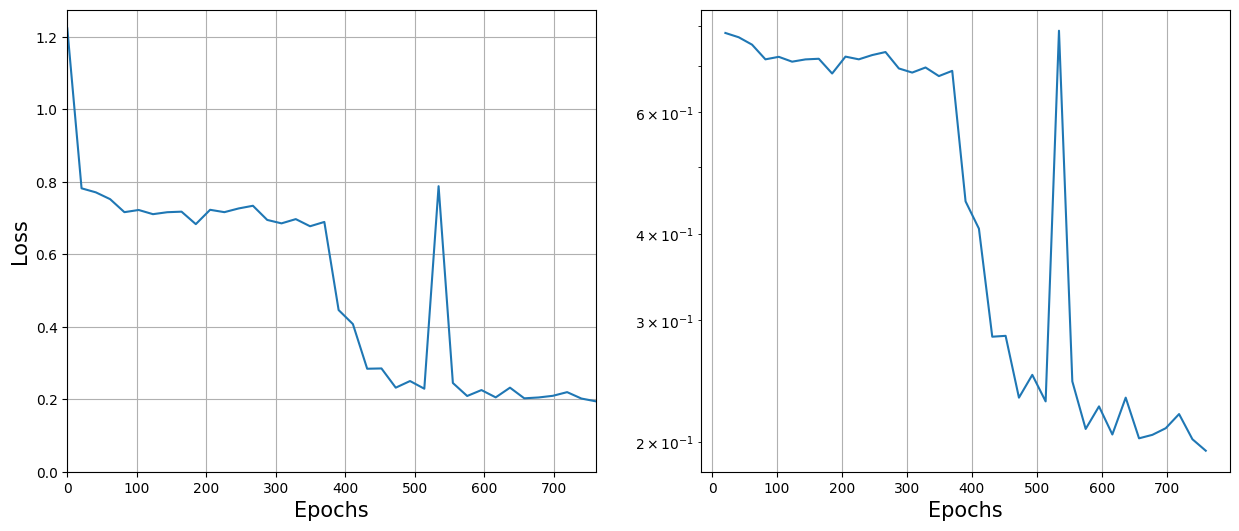

In [19]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [20]:
t_Start_pred = 0; t_Final_pred = 15
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

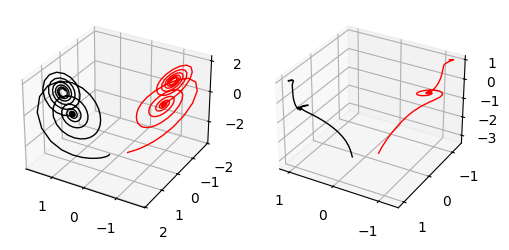

In [21]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[0, :, 0, 0], ys=training_data_tensor[0, :, 0, 1], zs=training_data_tensor[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[0, :, 1, 0], ys=training_data_tensor[0, :, 1, 1], zs=training_data_tensor[0, :, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()

In [52]:

def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[0, :index, 0, 0], ys=data_norm[0, :index, 0, 1], zs=data_norm[0, :index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[0, :index, 1, 0], ys=data_norm[0, :index, 1, 1], zs=data_norm[0, :index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

In [53]:
def plot_interact2(index):
        #Plotting results
        fig = plt.figure(figsize=(6, 8))

        #First Plot
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot(xs=training_data_tensor[0, :index, 0, 0], ys=training_data_tensor[0, :index, 0, 1], zs=training_data_tensor[0, :index, 0, 2], color = 'black', linewidth = 1 )
        ax1.plot(xs=training_data_tensor[0, :index, 1, 0], ys=training_data_tensor[0, :index, 1, 1], zs=training_data_tensor[0, :index, 1, 2], color = 'red', linewidth = 1 )

        #ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
        ax1.view_init(elev = 30, azim = 120)


        #Second Plot 
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot(xs=node_data[:index, 0, 0].detach().numpy(), ys=node_data[:index, 0, 1].detach().numpy(), zs=node_data[:index, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
        ax2.plot(xs=node_data[:index, 1, 0].detach().numpy(), ys=node_data[:index, 1, 1].detach().numpy(), zs=node_data[:index, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

        ax2.view_init(elev = 30, azim = 120)



In [47]:
node_data.shape

torch.Size([500, 2, 3])

In [48]:
model.break_params

Parameter containing:
tensor([8.2038], requires_grad=True)

In [54]:

interact(plot_interact2, index=IntSlider(min=0, max=500, step=1))

interactive(children=(IntSlider(value=0, description='index', max=500), Output()), _dom_classes=('widget-inter…

<function __main__.plot_interact2(index)>

## Bifurcation Diagram

In [ ]:
a = 1

In [ ]:
np.vectorize(lorenz.f)

In [ ]:
integ.solve_ivp(fun = np.vectorize(lorenz.f), t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', 
                t_eval = np.arange(t_Start, t_Final, dt), )




In [ ]:
r_eval = np.arange(0, 28, 0.1)
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]

t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [ ]:
x_list = []
r_list = []
for r in tqdm(r_eval):
    lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)
      



100%|██████████| 280/280 [02:05<00:00,  2.24it/s]
